# Module 2 Project Submission

* Student name: Miya Kusumoto
* Student pace: self paced
* Scheduled project review date/time: Friday, May 9, 2019; 12:00 pm CT
* Instructor name: Eli Thomas

## Executive Summary

### The Goal:
As the Northwind Company begins planning marketing, people, growth, and tech strategies for 2020, this analysis should help business leaders understand the following about customers, employees, and sales strategies:
* Discounts have a significant and meaningful effect on the quantity of items purchased by customers, however pricing and timing are important considerations when making these decisions.
* While the largest region is the Eastern Region, encompassing over 700 territories, the average order revenue remains the lowest. Focusing sales effort on smaller regions like the West where there are far more higher average orders could prove to be profitable. 
* Shipping/Freight prices do not appear to vary based on shipper. This is helpful in regional transport and efficiency planning, especially if there is a particular company who is more effective -- there is likely a marginal difference in pricing so it would be worth it to choose the best, most efficient shipper.


### Future Projects Include:
* Understanding whether the number of Sales Associates representing larger regions corresponds to the largest amount of revenue. This may be important when determining span of control, personnel decisions, or marketing budget allocation.
* Further exploration into Shippers and Suppliers to further optimize the operations management functions at Northwind. There may also be interest in understanding regional and time-based demand in order to become more predictive and rapid in order fulfillment. 
* Successful companies in this day and age are data companies at heart -- they know thier customers deeply and personally and are able to predict their needs and wants. To do this correctly, organizations should have robust data and customer management repositories. Data quality issues do appear to be present in this database so the recommendation is to validate the current data and eliminate any issues. 
* Offering discounts could help the business in moving stock, attracting new customers, and reaching sales targets during specific seasons. It is important to note, however, that we need to understand profit margin, gross sales figures, and breakeven points as quantity ordered may not be enough to surpass the revenue that would have been generated by selling a smaller quantity at no discount. I would like to conduct further analysis on pricing in order to determine when discounts should be offered and who they should be offered to. 



In [48]:
##import statements
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib as mpl

import sqlalchemy
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy import inspect
from sqlalchemy import MetaData
from sqlalchemy.ext.automap import automap_base

import sqlite3
import pandas as pd

from mpl_toolkits.basemap import Basemap

import scipy.stats as st
from scipy.stats import kurtosis
from scipy.stats import skew

import statsmodels.formula.api as smf
import statsmodels.api as sm
import scipy.stats as stats
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score



# Part 1: Obtain, Scrub, Explore

We will begin by obtaining our dataset. The steps that we have to take to acquire our data include: 
* Utilize SQL Alchemy to connect to the Northwind DB
* Use SQLAlchemy Session Objects to map our database to python classes
* Create a DataFrame from the necessary tables so that we can clean it up and analyze

Because our data is stored in a database and we do not want to pull in every table every time, we will repeat parts of this process for each of test question we decide to answer. 

In [2]:
#Utilize sqlalchemy to connect to our db
engine = create_engine("sqlite:///Northwind_small.sqlite", echo=True)
Session = sessionmaker(bind=engine)
session = Session()

In [3]:
#use inspector to get table names and understand what information is included in the database.
inspector = inspect(engine)

print(inspector.get_table_names())

2019-05-08 20:45:50,576 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-05-08 20:45:50,577 INFO sqlalchemy.engine.base.Engine ()
2019-05-08 20:45:50,579 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-05-08 20:45:50,581 INFO sqlalchemy.engine.base.Engine ()
2019-05-08 20:45:50,584 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-05-08 20:45:50,586 INFO sqlalchemy.engine.base.Engine ()
['Category', 'Customer', 'CustomerCustomerDemo', 'CustomerDemographic', 'Employee', 'EmployeeTerritory', 'Order', 'OrderDetail', 'Product', 'Region', 'Shipper', 'Supplier', 'Territory']


### Table Names are: 
- Category
- Customer
- CustomerCustomerDemo
- CustomerDemographic
- Employee
- EmployeeTerritory
- Order
- OrderDetail
- Product
- Region
- Shipper
- Supplier
- Territory

Now that we have the table names, we can check with the ERD to ensure that everything checks out. We can see that there are quite a few discrepancies in our table names. 

Looks like table names in the ERD are plural where in our actual DB they are singular. We will have to keep an eye on that when we begin to work with the tables. 

It is good that we now have a list of the exact column names included in our database. We will rely heavily on this as we begin pulling together multiple tables to answer more complicated questions. 

In [4]:
#lets look at the columns and data types included in our OrderDetail table.
#For the initial question, this is what we will be focusing on. 

print(inspector.get_columns("OrderDetail"))

2019-05-08 20:45:50,598 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("OrderDetail")
2019-05-08 20:45:50,600 INFO sqlalchemy.engine.base.Engine ()
[{'name': 'Id', 'type': VARCHAR(length=8000), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}, {'name': 'OrderId', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'ProductId', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'UnitPrice', 'type': DECIMAL(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'Quantity', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'Discount', 'type': FLOAT(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}]


The current structure is messy; let's write a function that allows us to see the table names in a clean and well-organized manner. The structure of the output from our .get_columns function is a list of dictionaries. 

In [5]:
def get_columns_info(col_name):
    cols_list = inspector.get_columns(col_name)
    
    print("Table Name: {}".format(col_name))
    print("")
    
    for col in cols_list:
        print("Name: {} \t Type: {}".format(col['name'], col['type']))

get_columns_info('OrderDetail')

Table Name: OrderDetail

Name: Id 	 Type: VARCHAR(8000)
Name: OrderId 	 Type: INTEGER
Name: ProductId 	 Type: INTEGER
Name: UnitPrice 	 Type: DECIMAL
Name: Quantity 	 Type: INTEGER
Name: Discount 	 Type: FLOAT


Now that we are able to obtain basic information about all of the tables in the dataset, let's revisit the initial question. We do this because it is important to understand what information in what tables we will need to pull from our database.

### Revisit the Question: Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

To answer this first question, we will likely only need the Order Detail table. As we were able to see from our exploration above, that table includes the **OrderID**, the **ProductID**, the **Unit Price**, the **Quantity**, and the **Discount**. This should be the extent of the information that we need in order to answer our question. 

Now let's get this OrderDetail table into a Pandas DataFrame so that we can easily explore and analyze it to hopefully answer our question. 

In [6]:
#This SQL query selects all rows and columns from my OrderDetail table and puts it into a dataframe. 

q = """SELECT * from OrderDetail"""

df1 = pd.read_sql_query(q, engine)
df1.head()

2019-05-08 20:45:50,619 INFO sqlalchemy.engine.base.Engine SELECT * from OrderDetail
2019-05-08 20:45:50,620 INFO sqlalchemy.engine.base.Engine ()


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [7]:
#what datatypes are each of my columns? I want to make sure they are casted correctly
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
Id           2155 non-null object
OrderId      2155 non-null int64
ProductId    2155 non-null int64
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 101.1+ KB


Above, we see that most of our columns are cast correctly. THe only two that I would like to change are the **OrderID** and **ProductID**. In this case I would like to keep them categorical so I will convert them to strings.

In [8]:
df1["OrderId"] = df1["OrderId"].astype("str")
df1["ProductId"] = df1["ProductId"].astype("str")

df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
Id           2155 non-null object
OrderId      2155 non-null object
ProductId    2155 non-null object
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 101.1+ KB


It appears that all my columns are the correct type and there are no missing values in any of the columns. Before we begin hypothesis testing, let's try to get a better understanding of what exactly is in each of the columns. Below I will describe the dataframe to see the mean, median, max, min, and standard deviation of my continuous variables. 

In [9]:
df1.describe()

,UnitPrice,Quantity,Discount
count,2155.000000,2155.000000,2155.000000
mean,26.218520,23.812993,0.056167
std,29.827418,19.022047,0.083450
min,2.000000,1.000000,0.000000
25%,12.000000,10.000000,0.000000
50%,18.400000,20.000000,0.000000
75%,32.000000,30.000000,0.100000
max,263.500000,130.000000,0.250000


In [10]:
print(len(df1["Discount"].unique()))
print(df1["Discount"].unique())

11
[0.   0.15 0.05 0.2  0.25 0.1  0.02 0.03 0.04 0.06 0.01]


<Figure size 1440x1440 with 0 Axes>

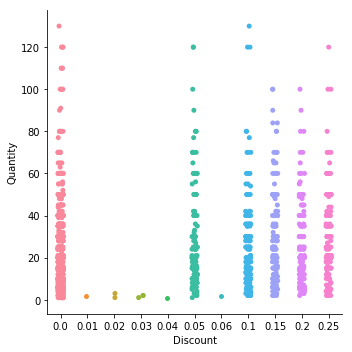

In [11]:
plt.figure(figsize = (20, 20))
sns.catplot(x="Discount", y="Quantity", jitter = True, data=df1);

In my description table, it doesn't appear that there are any outliers but the minimum price is \\$2 and the maximum price is \\$263.50. The majority of our products seem to be priced much lower in the \\$12 - \\$18 range. 

Quantities look pretty standard where most orders contain product quantities between 10 and 30 units. 

The Discount is more interesting and harder to understand based on the initial Describe output. To get insight into what discounts are present in the orders, I will check the unique values. There are 11 different discount percentages ranging from **0% (no discount) to 25%**. From the looks of my small visualization to better explain this, it appears that the majority of discounts fall in the **0%**, **5%**, **10%**, **15%**, **20%**, and **25%** buckets. 

To begin our hypothesis testing, we first need to see the distribution of the data so we know if our data is normally distributed.

/Users/miyakusumoto/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 0, 'Quantity of Product Ordered')

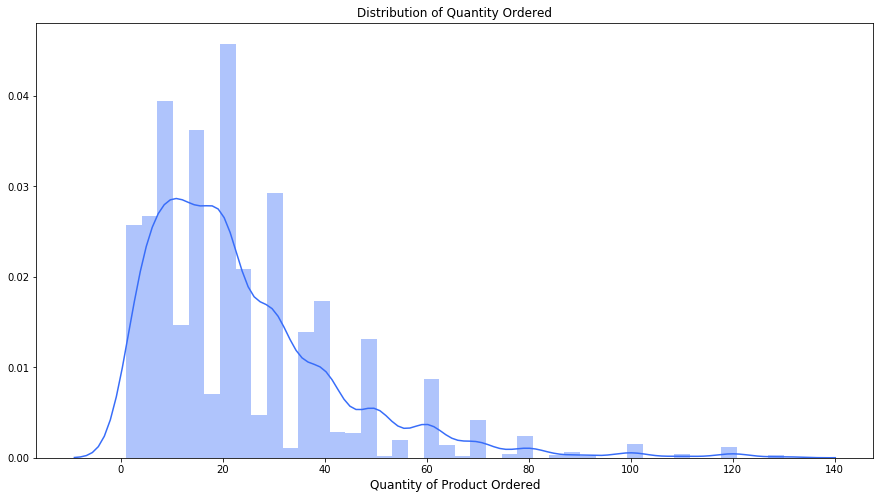

In [12]:
#visualize the distribution of the Quantity column
sns.set_palette('rainbow')

plt.figure(figsize=(15, 8))
sns.distplot(df1['Quantity']);
plt.title('Distribution of Quantity Ordered', fontsize=12)
plt.xlabel('Quantity of Product Ordered', fontsize=12)

The quantity of products ordered appears to be skewed to the right with varying quantities in between. Because it is not normally distributed, we will need to use the **Central Limit Theorem** to create a sample distribution of sample means that will be normally distributed so that we can utilize p-values and z-scores to answer our question. 

# Part 2: Experimental Design (Modeling + Interpreting)

Sound experimental design underpins every decision we make as a data scientist. To ensure my problem and experiment are set up properly, a few things will happen in this phase: 
 - **Control Group will be defined**: Our control group is the group that allows us to compare outcomes. In this case our control group will include orders with **no** discount. The control group is important because without it we would have no insight into how much of our results can be attributed to the discount. 
 - **Appropriate Sample Size**: Large sample sizes protect us from randomness and variance. 
 - **Reproducibility**: In this situation we won't have to focus on this too much, but we do want to ensure that this experiment has Reproducible Results. 

### Revisit the Question
Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

### Definining the Hypothesis


**Null Hypothesis ($H_O: \mu1 <= \mu_2$)**: The treatment group with a discount will not purchase larger quantities of a product in an order.

**Alternative Hypothesis ($H_a: \mu_1 > \mu_2$)**: The treatment group with a discount will purchase larger quantities of products in an order.

In this experiment I will be conducting a **_One-Tail Test_** because I want to know if the quantity of products in an order from the treatment group (orders **_with_** discount) is greater than the quantity of products per order from our control group (orders **_without_** discount). 

In this experiment we will also be dealing with **_Discrete_** data because the quantity of products in each order are integers. You can not buy half of a product. 

With this in mind, we know we conducting an **Upper/Right-Tailed** test.

### Test our Hypothesis: 
1. Divide our data into two groups: the **treatment group** and the **contol group**.
2. Check for **normality**. If our data is not normal (which we know from above, we will need to create a normal sample distribution.
3. Caluculate a few sample statistics: 
 - The population mean (μ).
 - The sample mean (x̄). Calculate from the sample data
 - The sample standard deviation (sigma). Calculate from sample data
 - Number of observations(n). Calculated from the sample data.
 - Degrees of Freedom(df). Calculate from the sample as df = total no. of observations - 1
4. Calcluate the **t-value** (because at this point we will know our normality, independence, and randomness requirements are satisfied)
5. Find the **Critical T-Value**
6. Compare t-values to accept or reject the Null Hypothesis ($H_O$)
7. Check for Type 1 and Type 2 Errors (and ensure a 95% confidence level is correct)




### 1. Treatment Group and Control Group
To be able to run our experiment, we need to divide our data into the treatment and control groups. 
 - The **Control Group** includes all item/quantity pairs where **_no_** discount was received
 - The **Treatment Group** is exactly the opposite and includes all item/quantity pairs where **_any_** discount was received. 

In [13]:
#Create my control and treatment groups by dividing up my dataframe
control = df1[df1['Discount'] == 0]
control = control['Quantity']
treatment = df1[df1['Discount'] != 0]
treatment = treatment['Quantity']

### 2. Normality 
Before we can make use of the normal distribution, we need to first confirm that our data is normally distributed. If it is not, then we'll need to use the Central Limit Theorem to create a sample distribution of sample means that will be normally distributed.

There are two main ways to check if a sample follows the normal distribution or not. The easiest is to simply plot the data and visually check if the data follows a normal curve or not.

/Users/miyakusumoto/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


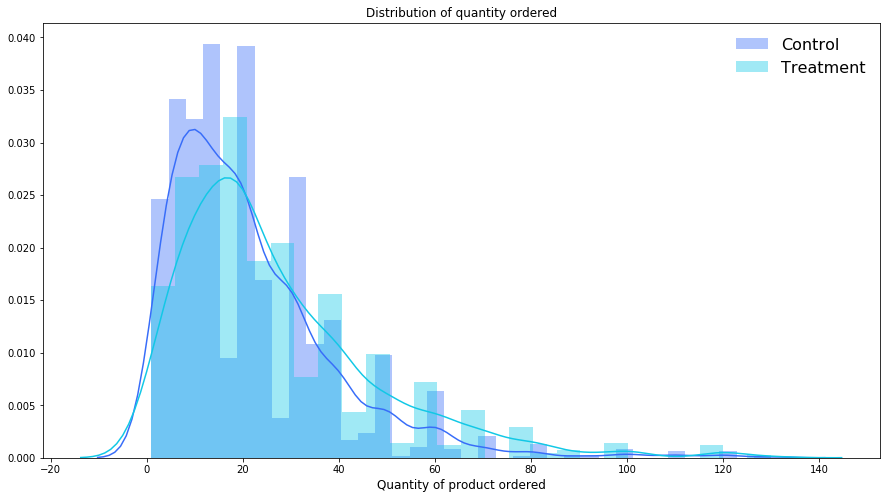

In [14]:
#First I will check normality visually
plt.figure(figsize=(15, 8))
sns.distplot(control, label='Control')
sns.distplot(treatment, label='Treatment')
plt.title('Distribution of quantity ordered', fontsize=12)
plt.xlabel('Quantity of product ordered', fontsize=12)
plt.legend(frameon=False, fontsize=16, loc='best')

In [15]:
#check normality using scipy normaltest function
print("Control:", st.normaltest(control))
print("Treatment:", st.normaltest(treatment))

Control: NormaltestResult(statistic=544.5770045551502, pvalue=5.579637380545965e-119)
Treatment: NormaltestResult(statistic=261.528012299789, pvalue=1.6214878452829618e-57)


Given the obvious visual cues that our data is not normal paired with our very low p-values for each group, we know that our data is not normally distributed. 

With that in mind, we'll need to use the Central Limit Theorem.

### 3. Sampling with Replacement
In order to create a Sample Distribution of Sample Means, we need to first write a function that can sample with replacement.

The cell below returns a random sample of our data. 

In [16]:
def get_sample(data, n):
    sample = []
    while len(sample) != n:
        x = np.random.choice(data)
        sample.append(x)
    
    return sample

def get_sample_mean(sample):
    return sum(sample) / len(sample)

def create_sample_distribution(data, dist_size=1000, n=500):
    sample_dist = []
    while len(sample_dist) != dist_size:
        sample = get_sample(data, n)
        sample_mean = get_sample_mean(sample)
        sample_dist.append(sample_mean)
    
    return sample_dist

In [17]:
#create sample distributions
ctrl_sample = create_sample_distribution(control)
tmt_sample = create_sample_distribution(treatment)

/Users/miyakusumoto/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


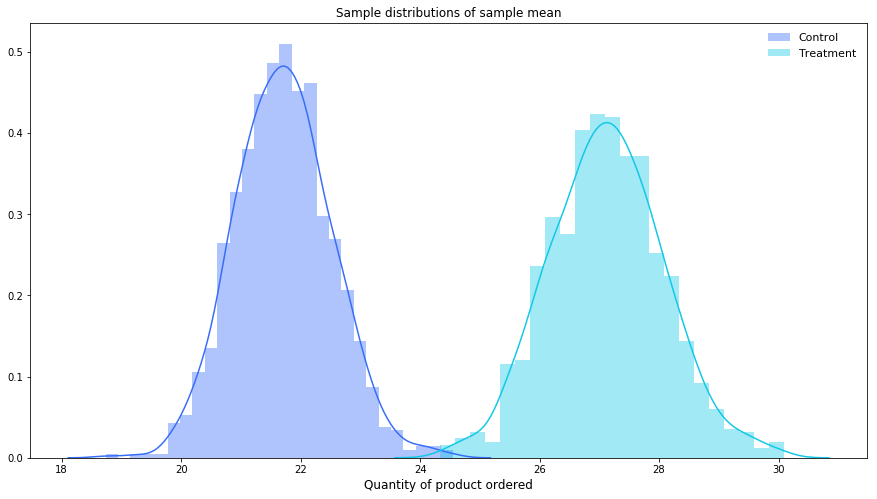

In [18]:
#Check and see if it worked!
plt.figure(figsize = (15, 8))
sns.distplot(ctrl_sample, label='Control')
sns.distplot(tmt_sample, label='Treatment')
plt.title('Sample distributions of sample mean', fontsize=12)
plt.xlabel('Quantity of product ordered', fontsize=12)
plt.legend(frameon=False, fontsize=11, loc='best')

This visualization of our normalized data makes it much more simple to see how a discount affects the quantity of product ordered. Let's run our T-Test to see if this is statistically significant.

In [19]:
#calculating test statistics

#population mean
mu = control.mean()
print("mu: ", mu)

#sample mean
x_bar = treatment.mean()
print("x-bar: ", x_bar)

#sigma
sigma = np.std(treatment, ddof=1)
print("standard deviation: ", sigma)

#Sample Size (n)
n = len(treatment)
print("n: ", n)

#difference in sample mean
diff = x_bar - mu

#calculate T-value
t = (x_bar -  mu)/(sigma/np.sqrt(n))
print("t: ", t)

mu:  21.715261958997722
x-bar:  27.10978520286396
standard deviation:  20.77143923484604
n:  838
t:  7.518106760070799


A positive t value indicates that the sample mean is greater than the population mean. This means that the sample's average sales performance with a discount is greater than average population sales performance. But is it statistically significant? Let's calculate the critical t-value.

In [20]:
# Calculate critical t value
t_crit = np.round(stats.t.ppf(1 - 0.05, df=837),3)
t_crit

1.647

With a critical t-value of 1.647 we can safely say (with 95% confidence) that a discount positively affects the quantity purchased. Now I want to understand what discount level causes a statistically significant effect. 

### 4. Which discount levels have the largest effect?  
I will begin by testing each of my individual discount levels (5%, 10%, 15%, 20%, 25%). I will do this in a similar way as my general experiment: 
1. Divide our data into two groups: the **treatment group** and the **contol group**.
2. Check for **normality**. If our data is not normal (which we know from above, we will need to create a normal sample distribution.
3. Caluculate a few sample statistics: 
 - The population mean (μ).
 - The sample mean (x̄). Calculate from the sample data
 - The sample standard deviation (sigma). Calculate from sample data
 - Number of observations(n). Calculated from the sample data.
 - Degrees of Freedom(df). Calculate from the sample as df = total no. of observations - 1
4. Calcluate the **t-value** (because at this point we will know our normality, independence, and randomness requirements are satisfied)
5. Find the **Critical T-Value**
6. Compare t-values to accept or reject the Null Hypothesis ($H_O$)
7. Check for Type 1 and Type 2 Errors (and ensure a 95% confidence level is correct)

In [21]:
treatment5 = df1[(df1['Discount'] >= .045)&(df1['Discount'] <= .055)] 
treatment5 = treatment5['Quantity']

treatment10 = df1[(df1['Discount'] >= .095)&(df1['Discount'] <= .105)] 
treatment10 = treatment10['Quantity']

treatment15 = df1[(df1['Discount'] >= .145)&(df1['Discount'] <= .155)] 
treatment15 = treatment15['Quantity']

treatment20 = df1[(df1['Discount'] >= .195)&(df1['Discount'] <= .205)] 
treatment20 = treatment20['Quantity']

treatment25 = df1[(df1['Discount'] >= .245)&(df1['Discount'] <= .255)] 
treatment25 = treatment25['Quantity']

discounts= ["treatment5","treatment10","treatment15","treatment20","treatment25"]

/Users/miyakusumoto/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 0, 'Quantity of product ordered')

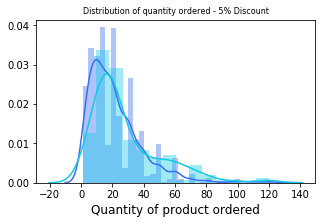

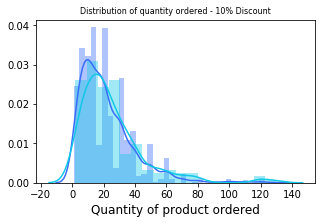

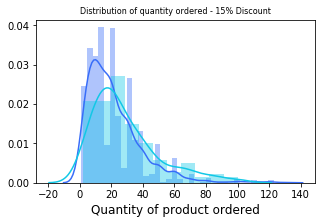

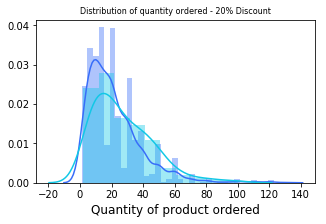

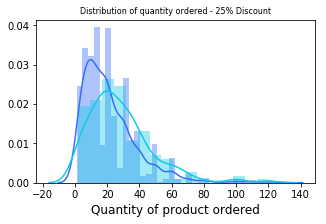

In [22]:
#First I will check normality visually

#Treatment at 5%
plt.figure(figsize = (5, 3))
sns.distplot(control, label='Control')
sns.distplot(treatment5, label="Treatment at 5% Discount")
plt.title('Distribution of quantity ordered - 5% Discount', fontsize=8)
plt.xlabel('Quantity of product ordered', fontsize=12)

#Treatment at 10%
plt.figure(figsize = (5, 3))
sns.distplot(control, label='Control')
sns.distplot(treatment10, label="Treatment at 10% Discount")
plt.title('Distribution of quantity ordered - 10% Discount', fontsize=8)
plt.xlabel('Quantity of product ordered', fontsize=12)

#Treatment at 15%
plt.figure(figsize = (5, 3))
sns.distplot(control, label='Control')
sns.distplot(treatment15, label="Treatment at 15% Discount")
plt.title('Distribution of quantity ordered - 15% Discount', fontsize=8)
plt.xlabel('Quantity of product ordered', fontsize=12)

#Treatment at 20%
plt.figure(figsize = (5, 3))
sns.distplot(control, label='Control')
sns.distplot(treatment20, label="Treatment at 20% Discount")
plt.title('Distribution of quantity ordered - 20% Discount', fontsize=8)
plt.xlabel('Quantity of product ordered', fontsize=12)

#Treatment at 25%
plt.figure(figsize = (5, 3))
sns.distplot(control, label='Control')
sns.distplot(treatment25, label="Treatment at 25% Discount")
plt.title('Distribution of quantity ordered - 25% Discount', fontsize=8)
plt.xlabel('Quantity of product ordered', fontsize=12)


In [23]:
#create sample distributions

ctrl_sample = create_sample_distribution(control)
tmt5_sample = create_sample_distribution(treatment5)
tmt10_sample = create_sample_distribution(treatment10)
tmt15_sample = create_sample_distribution(treatment15)
tmt20_sample = create_sample_distribution(treatment20)
tmt25_sample = create_sample_distribution(treatment25)


In [24]:
def one_sample_ttest(sample, popmean, alpha):

    # Visualize sample distribution for normality 
    sns.set(color_codes=True)
    sns.set(rc={'figure.figsize':(12,10)})
    sns.distplot(sample)
    
    # Populaqtion mean 
    mu = popmean
    
    # Sample mean (x̄) using NumPy mean()
    x_bar= sample.mean()

    # Sample Stadrad Deviation (sigma) using Numpy
    sigma = np.std(sample)
    
    # Degrees of freedom
    df = len(sample) - 1
    
    #Calculate the critical t-value
    t_crit = stats.t.ppf(1 - alpha, df=df)
    
    #Calculate the t-value and p-value
    results = stats.ttest_1samp(a= sample, popmean= mu)         
    
    if (results[0]>t_crit) and (results[1]<alpha):
        print ("Null hypothesis rejected. Results are statistically significant with t-value =", 
                round(results[0], 2), "critical t-value =", t_crit, "and p-value =", np.round((results[1]), 10))
    else:
        print ("Null hypothesis is True with t-value =", 
                round(results[0], 2), ", critical t-value =", t_crit, "and p-value =", np.round((results[1]), 10))

/Users/miyakusumoto/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Null hypothesis rejected. Results are statistically significant with t-value = 201.18 critical t-value = 1.646380345427535 and p-value = 0.0
Null hypothesis rejected. Results are statistically significant with t-value = 115.83 critical t-value = 1.646380345427535 and p-value = 0.0
Null hypothesis rejected. Results are statistically significant with t-value = 228.0 critical t-value = 1.646380345427535 and p-value = 0.0
Null hypothesis rejected. Results are statistically significant with t-value = 201.82 critical t-value = 1.646380345427535 and p-value = 0.0
Null hypothesis rejected. Results are statistically significant with t-value = 227.5 critical t-value = 1.646380345427535 and p-value = 0.0


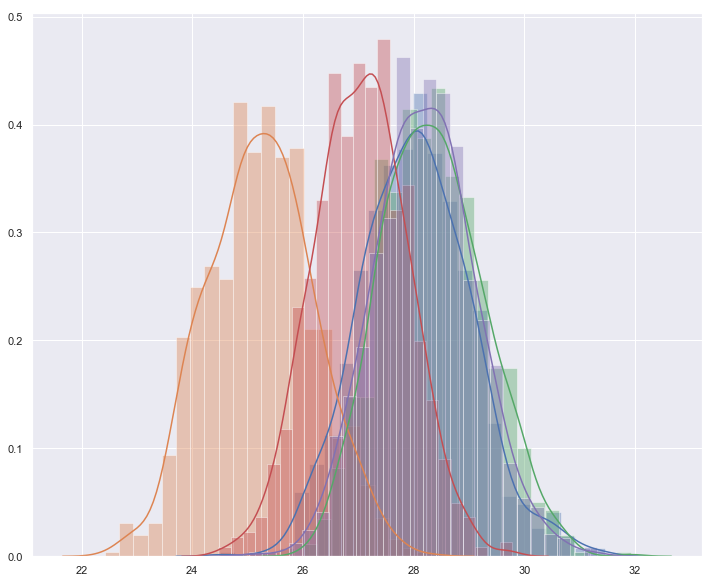

In [25]:
#list of samples
samples=[tmt5_sample, tmt10_sample, tmt15_sample, tmt20_sample, tmt25_sample]

#population mean
mu = control.mean()

#set alpha
alpha = 0.05

for s in samples:
    s = np.array(s)
    one_sample_ttest(s, mu, alpha)

### Closing Thoughts
Well, it appears at every inidividual level of discount, there are statistically significant results indicating that any level of discount between 5% and 25% has a significant effect on the quantity of products ordered. 

### Future Considerations
This is good to know as the business plans for future discounts. Offering discounts could help the business in moving stock, attracting new customers, and reaching sales targets during specific seasons. It is important to note, however, that we need to understand profit margin, gross sales figures, and breakeven points as quantity ordered may not be enough to surpass the revenue that would have been generated by selling a smaller quantity at no discount.

Future experiments could include:
- Forecasting with and without discounts to determine if it is a sound business decision to offer a discount. 
- Understanding purchasing behavior timing and preference; this would help the business to determine when the best time to offer a discount is.
- Determining the relationship between Price and Discount. Perhaps items that are more expensive sell in higher quantities when discounted

## Additional Questions: 
### Question 2: Do longer tenured employees bring in more revenue? 

Next I want to understand which employees bring in the most revenue. This is important because organizations can easily implement training programs geared toward specific subsections of employees. Newer employees don't bring in as much revenue? Create mentorship programs, training programs, and learning development series. More tenured employees don't bring in as much? Create training programs, badge programs, and merit awards.

To do this, I will need to combine several tables: OrderDetail, Order, and Employee

In [26]:
get_columns_info('OrderDetail')

Table Name: OrderDetail

Name: Id 	 Type: VARCHAR(8000)
Name: OrderId 	 Type: INTEGER
Name: ProductId 	 Type: INTEGER
Name: UnitPrice 	 Type: DECIMAL
Name: Quantity 	 Type: INTEGER
Name: Discount 	 Type: FLOAT


In [27]:
get_columns_info('Employee')

2019-05-08 20:46:20,712 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Employee")
2019-05-08 20:46:20,713 INFO sqlalchemy.engine.base.Engine ()
Table Name: Employee

Name: Id 	 Type: INTEGER
Name: LastName 	 Type: VARCHAR(8000)
Name: FirstName 	 Type: VARCHAR(8000)
Name: Title 	 Type: VARCHAR(8000)
Name: TitleOfCourtesy 	 Type: VARCHAR(8000)
Name: BirthDate 	 Type: VARCHAR(8000)
Name: HireDate 	 Type: VARCHAR(8000)
Name: Address 	 Type: VARCHAR(8000)
Name: City 	 Type: VARCHAR(8000)
Name: Region 	 Type: VARCHAR(8000)
Name: PostalCode 	 Type: VARCHAR(8000)
Name: Country 	 Type: VARCHAR(8000)
Name: HomePhone 	 Type: VARCHAR(8000)
Name: Extension 	 Type: VARCHAR(8000)
Name: Photo 	 Type: BLOB
Name: Notes 	 Type: VARCHAR(8000)
Name: ReportsTo 	 Type: INTEGER
Name: PhotoPath 	 Type: VARCHAR(8000)


In [28]:
get_columns_info('Order')

2019-05-08 20:46:20,722 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Order")
2019-05-08 20:46:20,723 INFO sqlalchemy.engine.base.Engine ()
Table Name: Order

Name: Id 	 Type: INTEGER
Name: CustomerId 	 Type: VARCHAR(8000)
Name: EmployeeId 	 Type: INTEGER
Name: OrderDate 	 Type: VARCHAR(8000)
Name: RequiredDate 	 Type: VARCHAR(8000)
Name: ShippedDate 	 Type: VARCHAR(8000)
Name: ShipVia 	 Type: INTEGER
Name: Freight 	 Type: DECIMAL
Name: ShipName 	 Type: VARCHAR(8000)
Name: ShipAddress 	 Type: VARCHAR(8000)
Name: ShipCity 	 Type: VARCHAR(8000)
Name: ShipRegion 	 Type: VARCHAR(8000)
Name: ShipPostalCode 	 Type: VARCHAR(8000)
Name: ShipCountry 	 Type: VARCHAR(8000)


In [29]:
#This SQL query selects the necessary rows and columns from my Order, Employee, and OrderDetail tables and put it into a dataframe. 
q = """SELECT EmployeeId, OrderDate, HireDate, Title, OrderId, ProductId, UnitPrice, Quantity
       FROM "Order" o 
       JOIN OrderDetail od on o.Id = od.OrderId
       JOIN Employee e on e.Id = o.EmployeeId
       """

df2 = pd.read_sql_query(q, engine)
df2.head()

2019-05-08 20:46:20,732 INFO sqlalchemy.engine.base.Engine SELECT EmployeeId, OrderDate, HireDate, Title, OrderId, ProductId, UnitPrice, Quantity
       FROM "Order" o 
       JOIN OrderDetail od on o.Id = od.OrderId
       JOIN Employee e on e.Id = o.EmployeeId
       
2019-05-08 20:46:20,733 INFO sqlalchemy.engine.base.Engine ()


,EmployeeId,OrderDate,HireDate,Title,OrderId,ProductId,UnitPrice,Quantity
0,5,2012-07-04,2025-10-17,Sales Manager,10248,11,14.0,12
1,5,2012-07-04,2025-10-17,Sales Manager,10248,42,9.8,10
2,5,2012-07-04,2025-10-17,Sales Manager,10248,72,34.8,5
3,6,2012-07-05,2025-10-17,Sales Representative,10249,14,18.6,9
4,6,2012-07-05,2025-10-17,Sales Representative,10249,51,42.4,40


In [30]:
#check data types in my new dataframe
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 8 columns):
EmployeeId    2155 non-null int64
OrderDate     2155 non-null object
HireDate      2155 non-null object
Title         2155 non-null object
OrderId       2155 non-null int64
ProductId     2155 non-null int64
UnitPrice     2155 non-null float64
Quantity      2155 non-null int64
dtypes: float64(1), int64(4), object(3)
memory usage: 134.8+ KB


Because I want to be able to check revenue of each employee, I am going to add a new column for total revenue per Order. I can then utilize this to understand how much each employee is bringing in.

In [31]:
#create new column for Total by multiplying Unit Price by Quantity
df2["totalrev"] = (df2["UnitPrice"]*df2["Quantity"])
df2.head()

,EmployeeId,OrderDate,HireDate,Title,OrderId,ProductId,UnitPrice,Quantity,totalrev
0,5,2012-07-04,2025-10-17,Sales Manager,10248,11,14.0,12,168.0
1,5,2012-07-04,2025-10-17,Sales Manager,10248,42,9.8,10,98.0
2,5,2012-07-04,2025-10-17,Sales Manager,10248,72,34.8,5,174.0
3,6,2012-07-05,2025-10-17,Sales Representative,10249,14,18.6,9,167.4
4,6,2012-07-05,2025-10-17,Sales Representative,10249,51,42.4,40,1696.0


Now that I have my main DataFrame, I just want to explore the data a bit to see what I will need to keep in mind as I begin visualizing and analyzing. I will look at how many Employees and then I will determine if Order Date matters. Basically I want to make sure that I am comparing apples to apples for each employee -- should I be looking at average sales over entire tenure or should I look only at the most recent year. 

In [32]:
#There are 9 employees at this organization
df2["EmployeeId"].unique()

array([5, 6, 4, 3, 9, 1, 8, 2, 7])

In [33]:
df2["OrderDate"].unique()

array(['2012-07-04', '2012-07-05', '2012-07-08', '2012-07-09',
       '2012-07-10', '2012-07-11', '2012-07-12', '2012-07-15',
       '2012-07-16', '2012-07-17', '2012-07-18', '2012-07-19',
       '2012-07-22', '2012-07-23', '2012-07-24', '2012-07-25',
       '2012-07-26', '2012-07-29', '2012-07-30', '2012-07-31',
       '2012-08-01', '2012-08-02', '2012-08-05', '2012-08-06',
       '2012-08-07', '2012-08-08', '2012-08-09', '2012-08-12',
       '2012-08-13', '2012-08-14', '2012-08-15', '2012-08-16',
       '2012-08-19', '2012-08-20', '2012-08-21', '2012-08-22',
       '2012-08-23', '2012-08-26', '2012-08-27', '2012-08-28',
       '2012-08-29', '2012-08-30', '2012-09-02', '2012-09-03',
       '2012-09-04', '2012-09-05', '2012-09-06', '2012-09-09',
       '2012-09-10', '2012-09-11', '2012-09-12', '2012-09-13',
       '2012-09-16', '2012-09-17', '2012-09-18', '2012-09-19',
       '2012-09-20', '2012-09-23', '2012-09-24', '2012-09-25',
       '2012-09-26', '2012-09-27', '2012-09-30', '2012-

In [34]:
df2["HireDate"].unique()

array(['2025-10-17', '2025-05-03', '2024-04-01', '2026-11-15',
       '2024-05-01', '2026-03-05', '2024-08-14', '2026-01-02'],
      dtype=object)

Uh oh, the reason it is important to explore data ahead of time is to ensure it is accurate and robust enough to answer the question at hand! In this instance it appears that the Hire Dates are inaccurate. The years are 10+ years ahead of the Order Dates! I don't feel comfortable making assumptions about this data so I will reevaluate and update my question a bit. 

This does bring up an important point though -- in order to be able to conduct relevant experiements and answer new questions, organizations need to put time and resources into proper data management practices. Proper IDs, accurate and updated information, and metadata management techniques are all important pieces of Data Scientistis being able to conduct relevant and useful experiments. 


### Question 3: Is there a significant difference in the profitablity of regions?

I will begin by pulling in the necessary tables using SQL Alchemy and the steps outlined when answering my initial question.

In [35]:
#This SQL query selects the necessary rows and columns from my Order, Employee, and OrderDetail tables and put it into a dataframe. 
q = """SELECT o.Id as OrderId, o.OrderDate, od.UnitPrice, od.Quantity, od.Discount, e.LastName, e.FirstName, e.Title, t.Id, t.TerritoryDescription, r.RegionDescription
       FROM "Order" o 
       JOIN OrderDetail od on o.Id = od.OrderId
       JOIN Employee e on e.Id = o.EmployeeId
       JOIN EmployeeTerritory et on et.EmployeeId = e.Id
       JOIN Territory t on t.Id = et.TerritoryId
       JOIN Region r on r.Id = t.RegionId
       """

df2 = pd.read_sql_query(q, engine)
df2.head()

2019-05-08 20:46:20,831 INFO sqlalchemy.engine.base.Engine SELECT o.Id as OrderId, o.OrderDate, od.UnitPrice, od.Quantity, od.Discount, e.LastName, e.FirstName, e.Title, t.Id, t.TerritoryDescription, r.RegionDescription
       FROM "Order" o 
       JOIN OrderDetail od on o.Id = od.OrderId
       JOIN Employee e on e.Id = o.EmployeeId
       JOIN EmployeeTerritory et on et.EmployeeId = e.Id
       JOIN Territory t on t.Id = et.TerritoryId
       JOIN Region r on r.Id = t.RegionId
       
2019-05-08 20:46:20,832 INFO sqlalchemy.engine.base.Engine ()


,OrderId,OrderDate,UnitPrice,Quantity,Discount,LastName,FirstName,Title,Id,TerritoryDescription,RegionDescription
0,10248,2012-07-04,14.0,12,0.0,Buchanan,Steven,Sales Manager,02903,Providence,Eastern
1,10248,2012-07-04,14.0,12,0.0,Buchanan,Steven,Sales Manager,07960,Morristown,Eastern
2,10248,2012-07-04,14.0,12,0.0,Buchanan,Steven,Sales Manager,08837,Edison,Eastern
3,10248,2012-07-04,14.0,12,0.0,Buchanan,Steven,Sales Manager,10019,New York,Eastern
4,10248,2012-07-04,14.0,12,0.0,Buchanan,Steven,Sales Manager,10038,New York,Eastern


In [36]:
#create new column for Total by multiplying Unit Price by Quantity and factoring in any discount
df2["totalrev"] = (df2["UnitPrice"]*df2["Quantity"])*(1-df2["Discount"])
df2.head()

,OrderId,OrderDate,UnitPrice,Quantity,Discount,LastName,FirstName,Title,Id,TerritoryDescription,RegionDescription,totalrev
0,10248,2012-07-04,14.0,12,0.0,Buchanan,Steven,Sales Manager,02903,Providence,Eastern,168.0
1,10248,2012-07-04,14.0,12,0.0,Buchanan,Steven,Sales Manager,07960,Morristown,Eastern,168.0
2,10248,2012-07-04,14.0,12,0.0,Buchanan,Steven,Sales Manager,08837,Edison,Eastern,168.0
3,10248,2012-07-04,14.0,12,0.0,Buchanan,Steven,Sales Manager,10019,New York,Eastern,168.0
4,10248,2012-07-04,14.0,12,0.0,Buchanan,Steven,Sales Manager,10038,New York,Eastern,168.0


In [37]:
#I want to see the sum revenue of each Order. To do this I will use the GroupBy functions.
df2.groupby('OrderId')['totalrev'].sum()

OrderId
10248     3080.000
10249     9317.000
10250     4657.800
10251     2616.240
10252    10793.700
10253     5779.200
10254     3896.340
10255    17433.500
10256     2071.200
10257     3359.700
10258     3229.760
10259      302.400
10260     4513.950
10261     1344.000
10262     2336.000
10263    13116.600
10264     3478.125
10265     8232.000
10266     1386.240
10267    10609.800
10268     4404.800
10269     4495.400
10270     2752.000
10271      240.000
10272     7280.000
10273     8149.120
10274     2693.000
10275      583.680
10276     1680.000
10277     8405.600
           ...    
11048     5250.000
11049     1094.400
11050     3240.000
11051      360.000
11052     5328.000
11053    21385.000
11054     1220.000
11055    17275.000
11056    14960.000
11057      180.000
11058     6006.000
11059    12866.000
11060     1862.000
11061     1530.000
11062     1219.200
11063     5371.800
11064     8660.800
11065      757.680
11066     9287.500
11067      173.700
11068     8108.320
1106

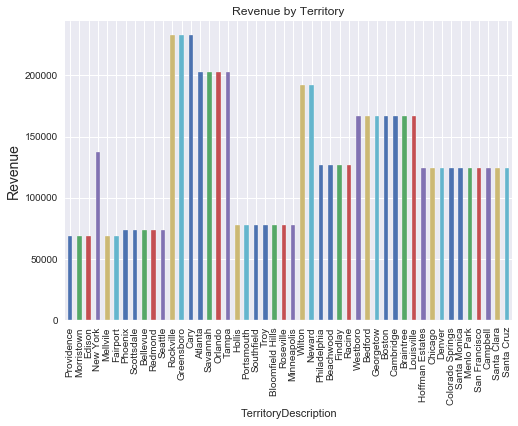

In [51]:
#I want to see the total revenue for each Territory

mpl.style.use("seaborn")

grouped = df2.groupby('TerritoryDescription', sort=False)['totalrev'].sum()
grouped.sort_index(ascending=True)
grouped.plot(kind='bar')

plt.ylabel("Revenue", fontsize=14)
plt.title("Revenue by Territory")
plt.show()

Well this is a good visualization, but it is a bit hard to read. First it might be a good idea to check and see if there is a significant difference in broader regions. I'll do the same thing but group by my regions. I also want to know how many territories are in each of my regions.

In [39]:
df2.groupby('RegionDescription', sort=False)['totalrev'].nunique()

RegionDescription
Eastern     741
Western     284
Southern    277
Northern    317
Name: totalrev, dtype: int64

There are significantly more territories in the Eastern Region! So it wouldn't be apples to apples if we attempted to compare the initial revenue figures. So I may need to revise my initial question a bit.

### Revisit the question: Does the average revenue per order vary dependent on the region? 

To define my null and alternate hypotheses: 

**Null Hypothesis**: On average, the revenue per order does not change region to region. 

**Alternative Hypothesis**: On average, the revenue per order *does* vary region to region (it is either higher or lower on average) 

In this instance, we will be conducting a 2-tailed test.

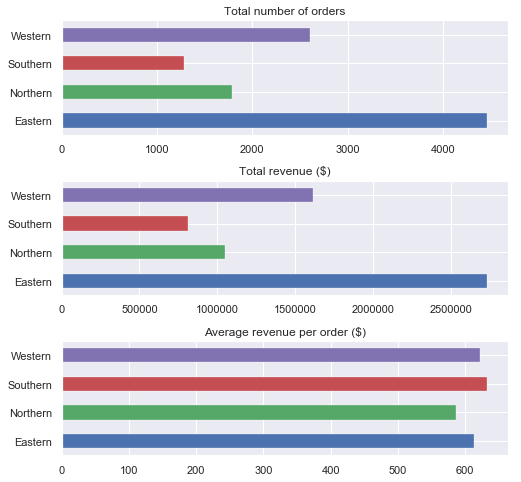

In [49]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8,8))

mpl.style.use("seaborn")
#Plot my Count, Sum, and Average by region
df2.groupby(['RegionDescription'])['RegionDescription'].count().plot(kind='barh', ax=ax1)
df2.groupby(['RegionDescription'])['totalrev'].sum().plot(kind='barh', ax=ax2)
df2.groupby(['RegionDescription'])['totalrev'].mean().plot(kind='barh', ax=ax3)

ax1.set_title('Total number of orders')
ax1.set_ylabel('')
ax2.set_title('Total revenue ($)')
ax2.set_ylabel('')
ax3.set_title('Average revenue per order ($)')
ax3.set_ylabel('')

fig.subplots_adjust(hspace=0.4);

Now I want to be able to just test my revenue per order so I can answer my test question. To do this, I will create a new dataframe with just my regions and my revenue per order.

In [41]:
df3=df2.drop(["OrderDate","LastName","FirstName","Title","Id","TerritoryDescription"], axis=1)
df3 = df3.groupby(['RegionDescription', 'OrderId'])['totalrev'].sum().reset_index()
df3.head()

,RegionDescription,OrderId,totalrev
0,Eastern,10248,3080.00
1,Eastern,10250,4657.80
2,Eastern,10252,10793.70
3,Eastern,10254,3896.34
4,Eastern,10257,3359.70


/Users/miyakusumoto/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


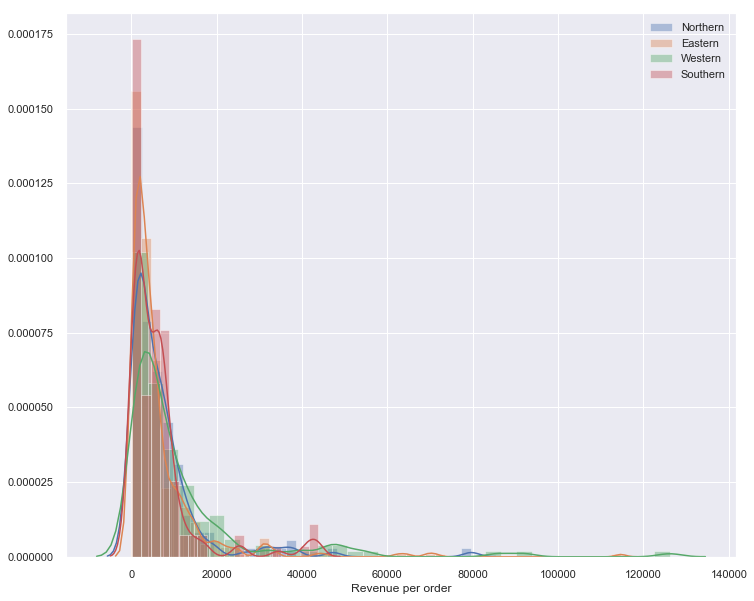

In [58]:
#Plot probability distributions for samples to visually inspect the differences between and standard deviation. 
#Let's plot both samples' distributions and inspect the overlap.

sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})

for region in set(df3.RegionDescription):
    region_group = df3.loc[df3['RegionDescription'] == region]
    sns.distplot(region_group['totalrev'], label=region)
    plt.legend()
    plt.xlabel('Revenue per order')

What's interesting here is that while the total revenue and the number of orders is significantly larger in the Eastern region, the average revenue is relatively similar for each of the four regions at hand. Additionally, some of the highest revenue (and even creating long tails/skewing the data is the western region). This distribution chart shows us that a large number of the orders from the Southern region -- while numerous are not all that profitable.

### Normalizing our Data and One Hot Encoding

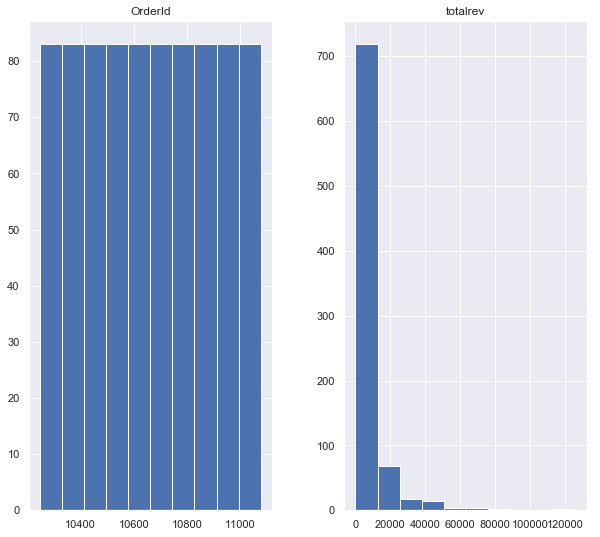

In [42]:
df3.hist(figsize = (10,9));

In [43]:
df3.describe().columns


Index(['OrderId', 'totalrev'], dtype='object')

## Visualizing distributions, KDEs, and Probability Densities


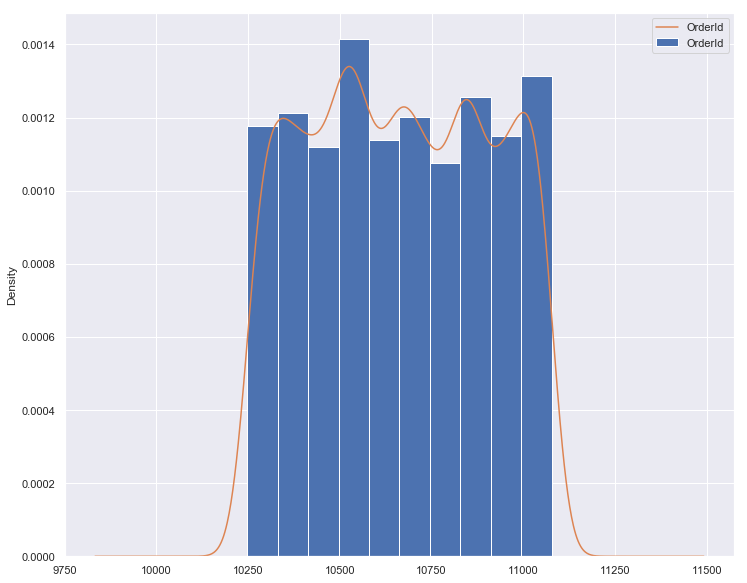

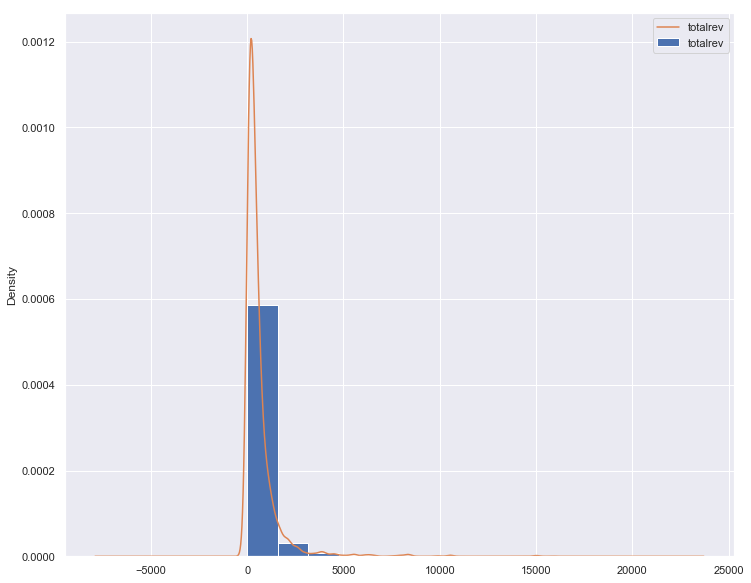

In [44]:
for column in ['OrderId', 'totalrev']:
    df2[column].plot.hist(density=True )
    df2[column].plot.kde(label=column )
    plt.legend()
    plt.show();

Looks like our Revenue column is skewed to the left with a long right tail. 

/Users/miyakusumoto/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


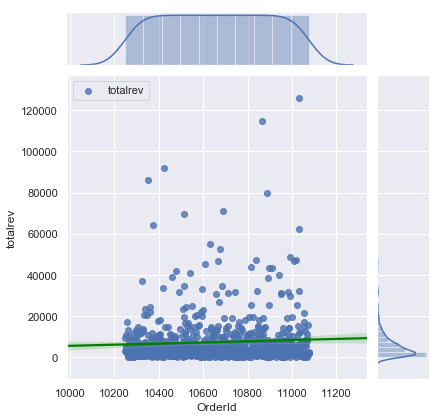

In [45]:
sns.jointplot(x="OrderId", y="totalrev",
                  data=df3, 
                  kind='reg', 
                  label=column,
                  joint_kws={'line_kws':{'color':'green'}})
plt.legend()
plt.show();

/Users/miyakusumoto/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


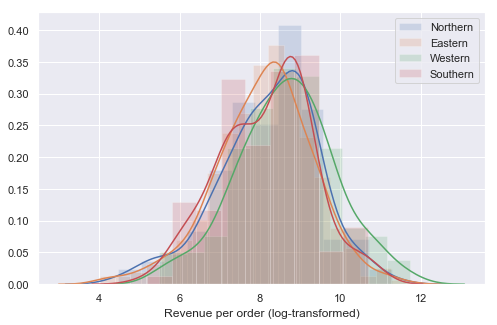

In [46]:
# Copying the dataset and log-transforming price_per_order
df3_log = df3.copy()
df3_log['totalrev'] = np.log(df3['totalrev'])

# Plotting the distributions for the log-transformed data
plt.figure(figsize=(8,5))
for region in set(df3_log.RegionDescription):
    region_group = df3_log.loc[df3_log['RegionDescription'] == region]
    sns.distplot(region_group['totalrev'], hist_kws=dict(alpha=0.2), label=region)
    plt.legend()
    plt.xlabel('Revenue per order (log-transformed)')

In [61]:
# Fitting a model of price_per_order on Region categories, and using statsmodels to compute an ANOVA table
results = ols('totalrev ~ C(RegionDescription)', data = df3).fit()
table = sm.stats.anova_lm(results, typ=2)
print(table)

results = ols('totalrev ~ C(RegionDescription)', data = df3_log).fit()
table = sm.stats.anova_lm(results, typ=2)
print(table)

                            sum_sq     df         F    PR(>F)
C(RegionDescription)  2.914924e+09    3.0  7.230734  0.000086
Residual              1.109951e+11  826.0       NaN       NaN
                          sum_sq     df         F    PR(>F)
C(RegionDescription)    31.53059    3.0  7.185316  0.000092
Residual              1208.21726  826.0       NaN       NaN


The ANOVA table above revealed that the p-value is lower than the alpha value of 0.05. In this case we can reject the null hypothesis and accept that there is a significant difference in the average revenue per order based on region. This is surprising because the average revenue per order appeared to be about the same in our initial exploration. With this analysis, we can posit that the higher average order prices for smaller western regions are actually profitable -- it may be important to begin exploring new, higher-priced product offerings to territories in the west. 

### Question 4: Does freight price vary significantly across shipping companies?

Let's define my null and alternate hypotheses: 

**Null Hypothesis**: On average, the freight price does not change company to company. 

**Alternative Hypothesis**: On average, the freight price *does* vary company to company (it is either higher or lower on average) 

In this instance, we will be conducting a 2-tailed test.

In [62]:
#This SQL query selects the necessary rows and columns from my Order, Employee, and OrderDetail tables and put it into a dataframe. 
q = """SELECT CompanyName, Freight, "Order".ID
             FROM Shipper
             JOIN "Order"
             ON Shipper.ID = ShipVia;"""

df4 = pd.read_sql_query(q, engine)
df4.head()



2019-05-08 21:38:18,065 INFO sqlalchemy.engine.base.Engine SELECT CompanyName, Freight, "Order".ID
             FROM Shipper
             JOIN "Order"
             ON Shipper.ID = ShipVia;
2019-05-08 21:38:18,066 INFO sqlalchemy.engine.base.Engine ()


,CompanyName,Freight,Id
0,Federal Shipping,32.38,10248
1,Speedy Express,11.61,10249
2,United Package,65.83,10250
3,Speedy Express,41.34,10251
4,United Package,51.30,10252


In [64]:
#Let's take a look at how many values we have for each company

df4['CompanyName'].value_counts()

United Package      326
Federal Shipping    255
Speedy Express      249
Name: CompanyName, dtype: int64

/Users/miyakusumoto/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


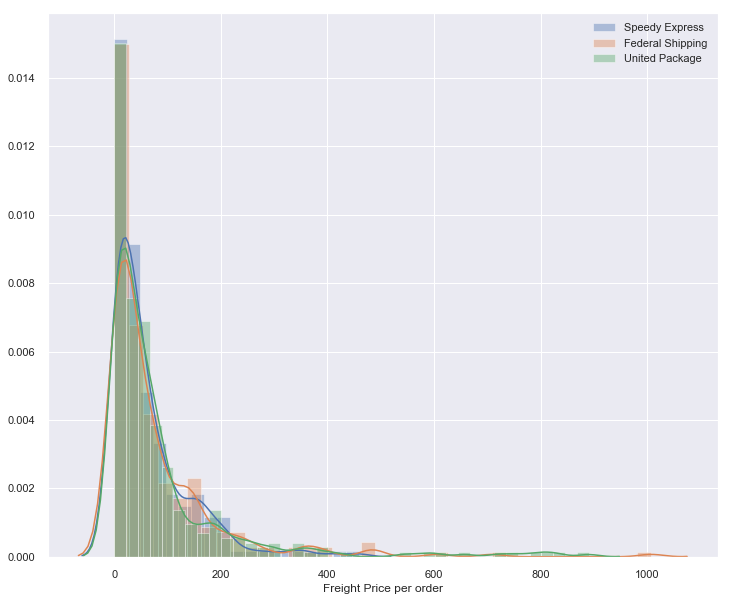

In [70]:
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})

for company in set(df4.CompanyName):
    company_group = df4.loc[df4['CompanyName'] == company]
    sns.distplot(company_group['Freight'], label=company)
    plt.legend()
    plt.xlabel('Freight Price per order')

In [74]:
results = ols('Freight ~ C(CompanyName)', data = df4).fit()
table = sm.stats.anova_lm(results, typ=2)
print(table)

                      sum_sq     df        F    PR(>F)
C(CompanyName)  6.788200e+04    2.0  2.49781  0.082885
Residual        1.123753e+07  827.0      NaN       NaN


/Users/miyakusumoto/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


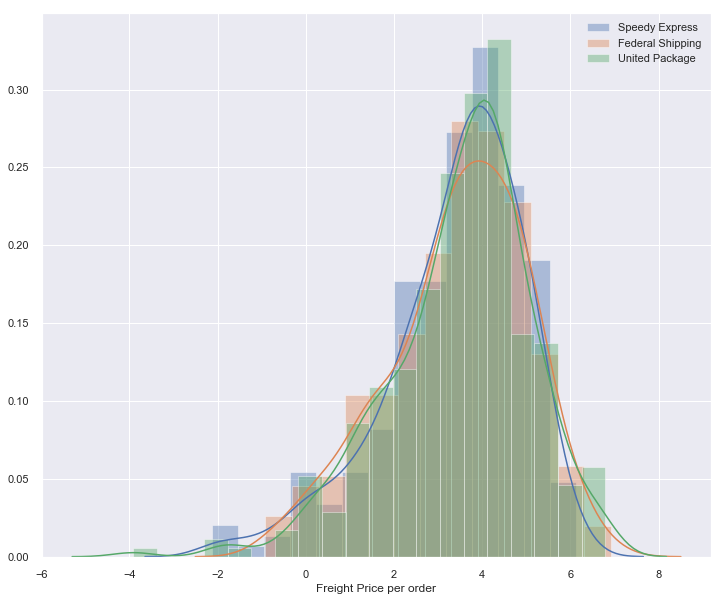

In [73]:
#log transform to make the distributions a bit more normal 

# Copying the dataset and log-transforming price_per_order
df4_log = df4.copy()
df4_log['Freight'] = np.log(df4['Freight'])

# Plotting the distributions for the log-transformed data
for company in set(df4_log.CompanyName):
    company_group = df4_log.loc[df4_log['CompanyName'] == company]
    sns.distplot(company_group['Freight'], label=company)
    plt.legend()
    plt.xlabel('Freight Price per order')

In [75]:
results = ols('Freight ~ C(CompanyName)', data = df4_log).fit()
table = sm.stats.anova_lm(results, typ=2)
print(table)

                     sum_sq     df         F    PR(>F)
C(CompanyName)     1.816553    2.0  0.361166  0.696973
Residual        2079.778316  827.0       NaN       NaN


The ANOVA table above revealed that the p-value is greater than the alpha value of 0.05. In this case we **fail to reject the null hypothesis** it will take further experimentation to understand if the shipping prices are different from each shipper -- but for now there doesn't appear to be any statistically significant variation. 

## Concluding Thoughts

* Discounts have a significant and meaningful effect on the quantity of items purchased by customers, however pricing and timing are important considerations when making these decisions.
* While the largest region is the Eastern Region, encompassing over 700 territories, the average order revenue remains the lowest. Focusing sales effort on smaller regions like the West where there are far more higher average orders could prove to be profitable. 
* Shipping/Freight prices do not appear to vary based on shipper. This is helpful in regional transport and efficiency planning, especially if there is a particular company who is more effective -- there is likely a marginal difference in pricing so it would be worth it to choose the best, most efficient shipper. 

### Future Projects Include:
* Understanding whether the number of Sales Associates representing larger regions corresponds to the largest amount of revenue. This may be important when determining span of control, personnel decisions, or marketing budget allocation.
* Further exploration into Shippers and Suppliers to further optimize the operations management functions at Northwind. There may also be interest in understanding regional and time-based demand in order to become more predictive and rapid in order fulfillment. 
* Successful companies in this day and age are data companies at heart -- they know thier customers deeply and personally and are able to predict their needs and wants. To do this correctly, organizations should have robust data and customer management repositories. Data quality issues do appear to be present in this database so the recommendation is to validate the current data and eliminate any issues. 
* Offering discounts could help the business in moving stock, attracting new customers, and reaching sales targets during specific seasons. It is important to note, however, that we need to understand profit margin, gross sales figures, and breakeven points as quantity ordered may not be enough to surpass the revenue that would have been generated by selling a smaller quantity at no discount. I would like to conduct further analysis on pricing in order to determine when discounts should be offered and who they should be offered to. 